In [3]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf

In [4]:
#tf.__version__

## A. Fashion MNIST

In [5]:
# Load data.

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
label_indicies = ["tshirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle_boot"]
x_train.shape, y_train.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

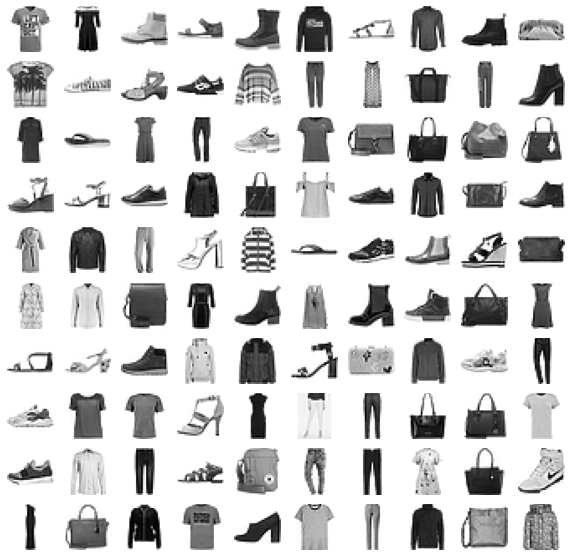

In [6]:
##### Plot random images.

idx = np.random.permutation(np.arange(len(x_train)))[:100]
plt.figure(figsize=(10,10))
for i, id_ in enumerate(idx):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    plt.imshow(x_train[id_], cmap="gray_r")
plt.show()

### 1. Discriminator Model

Here discriminator takes two inputs:
1. An input image either generated by generator or a real image.
2. An integer class label.

**We don't need to convert class label to one-hot, as it is passed to embedding layer and this layers takes integers as input (not one-hot vectors).** The class label goes through following steps:
1. Converted to an embedding with not very high dimensionality (e.g. with dimensionality 50)
2. Upsamples to dimension 28*28
3. Reshaped to shape (28,28)
4. Appended to input image as a new channel.

In [7]:
def discriminator_model(img_shape=(28,28,1), n_classes=10):
    # Prepare a single channel from label.
    label_in = tf.keras.layers.Input(shape=[1]) # shape is 1 as it is single integer
    label_embedding = tf.keras.layers.Embedding(input_dim=n_classes, output_dim=50)(label_in)
    label_upsample = tf.keras.layers.Dense(img_shape[0]*img_shape[1])(label_embedding) # Activation is linear as we are just upsampling.
    label_reshaped = tf.keras.layers.Reshape(target_shape=[img_shape[0], img_shape[1], 1])(label_upsample)
    
    # Image input.
    img_in = tf.keras.layers.Input(shape=img_shape)
    img_concat = tf.concat([img_in, label_reshaped], axis=-1)
    
    # Now perform regular convolution steps.
    x = img_concat
    
    x = tf.keras.layers.Conv2D(128,(3,3), strides=(2,2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128,(3,3), strides=(2,2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model = tf.keras.Model([img_in, label_in], x)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model
                                             
                                             
discriminator_model()

### 2. Generator Model

Generator takes two inputs:
1. Random latent vector Z.
2. Integer class label

Class label goes through following steps:
1. Class label is passed through an embedding layer to create vector of length 50.
2. This embedding vector is then passed through a Dense layer with linear activation.
3. This output is then reshaped and concatenated to reshaped latent input.

In [8]:
def generator_model(latent_dim, n_classes=10):
    # Create a single channel from class label.
    label_in = tf.keras.layers.Input(shape=[1])
    label_embedding = tf.keras.layers.Embedding(input_dim=n_classes, output_dim=50)(label_in)
    label_upsampled = tf.keras.layers.Dense(7*7)(label_embedding)
    label_reshaped = tf.keras.layers.Reshape(target_shape=[7,7,1])(label_upsampled)
    
    # Latent input.
    latent_in = tf.keras.layers.Input(shape=[latent_dim])
    latent_upsampled = tf.keras.layers.Dense(7*7*128)(latent_in)
    latent_upsampled = tf.keras.layers.LeakyReLU(0.3)(latent_upsampled)
    latent_reshaped = tf.keras.layers.Reshape(target_shape=[7,7,128])(latent_upsampled)
    
    x_concat = tf.concat([latent_reshaped, label_reshaped], axis=-1)
    
    # Now perform regular generator steps.
    x = x_concat
    
    x = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    
    x = tf.keras.layers.Conv2D(1,(4,4), padding="same", activation="tanh")(x)
    model = tf.keras.Model([latent_in, label_in], x)
    return model
    
# latent_in = np.random.randn(32, 100)
# labels_fake = np.random.randint(low=0, high=10, size=(32))
g = generator_model(100)


### 3. GAN Model

GAN Model is a combination of generator and discriminator.

In [9]:
def gan_model(gen, dis):
    dis.trainable = False
    latent_in, label_in = gen.input
    gen_out = gen.output
    
    dis_out = dis([gen_out, label_in])
    
    model = tf.keras.Model([latent_in, label_in], dis_out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model
    
gan_model(gen=generator_model(latent_dim=100, n_classes=10),
          dis=discriminator_model())

### 4. Train the model.

In [39]:
def plot_generated(gen, latent_dim, labels=None, n_classes=10):
    batch_size=25
    latent_in = np.random.randn(batch_size, latent_dim)
    labels_fake = np.random.randint(low=0, high=n_classes, size=(batch_size))
    imgs_fake = gen.predict([latent_in, labels_fake])
    imgs_fake = (imgs_fake + 1) / 2.0
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5,5,i+1)        
        plt.imshow(imgs_fake[i,:,:,0], cmap="gray_r")
        plt.title(label_indicies[labels_fake[i]])
        plt.axis("off")
    plt.show()
    

In [40]:
def train(gan, gen, dis, latent_dim, imgs, labels, n_classes=10, epochs=10, batch_size=32):
    # Normalize images in range [-1,1]
    imgs = (imgs - 127.0)/127.0
    N = len(imgs)
    n_batches = N // batch_size
    train_loss_gen = []
    train_loss_dis = []
    for epoch in range(epochs):
        for batch in range(n_batches):
            #################### Discriminator.
            # Real img and labels.
            imgs_real = imgs[batch*batch_size : (batch+1)*batch_size]
            labels_real = labels[batch*batch_size : (batch+1)*batch_size]
            # Latent vec and labels.
            latent_in = np.random.randn(batch_size, latent_dim)
            labels_fake = np.random.randint(low=0, high=n_classes, size=(batch_size))
            imgs_fake = gen.predict([latent_in, labels_fake])
            
            # Train discriminator.
            #print(imgs_real.shape, imgs_fake.shape)
            d_in_imgs = np.concatenate([imgs_real, np.squeeze(imgs_fake)])
            d_in_labels = np.concatenate([labels_real, labels_fake])
            # While training discriminator real are considered 1 and fake as 0.
            d_y = np.concatenate([np.ones(shape=(batch_size,)), np.zeros(shape=(batch_size,))])
            # Train discriminator on current batch.
            d_in_imgs = np.expand_dims(d_in_imgs, axis=3)
            d_loss, d_acc = dis.train_on_batch([d_in_imgs, d_in_labels], d_y)
            
            ##################### Generator
            # For generator output y is 1 for fake samples. (opposite of discriminator training)
            latent_in = np.random.randn(batch_size*2, latent_dim)
            labels_fake = np.random.randint(low=0, high=n_classes, size=(batch_size*2))
            g_y = np.ones(shape=(batch_size*2))
            g_loss, g_acc = gan.train_on_batch([latent_in, labels_fake], g_y)
            
            sys.stdout.write("\r{}/{} Epoch:{}/{} \tg_loss:{} \td_loss:{}".format(batch+1, n_batches, epoch, epochs, g_loss, d_loss))
        print()
        plot_generated(gen, latent_dim, labels=None, n_classes=10)
        train_loss_gen.append(g_loss)
        train_loss_dis.append(d_loss)
    return train_loss_gen, train_loss_dis

In [41]:
dis = discriminator_model()
gen = generator_model(100)
gan = gan_model(gen, dis)

1875/1875 Epoch:0/10 	g_loss:0.8501162528991699 	d_loss:0.59934991598129274


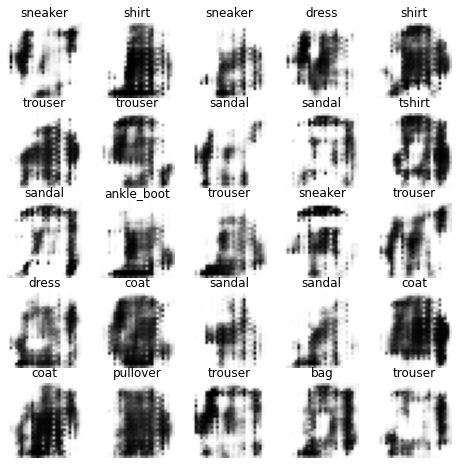

1875/1875 Epoch:1/10 	g_loss:0.773491621017456 	d_loss:0.721162319183349647


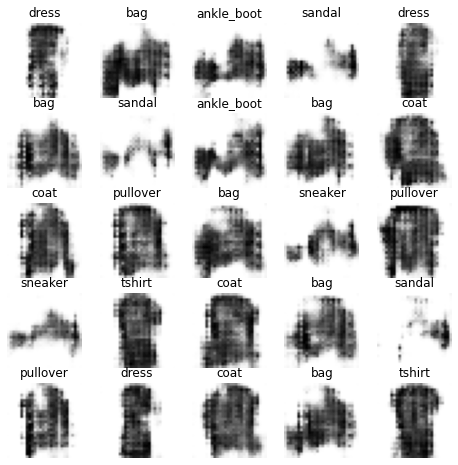

1875/1875 Epoch:2/10 	g_loss:0.8952105045318604 	d_loss:0.56767046451568643


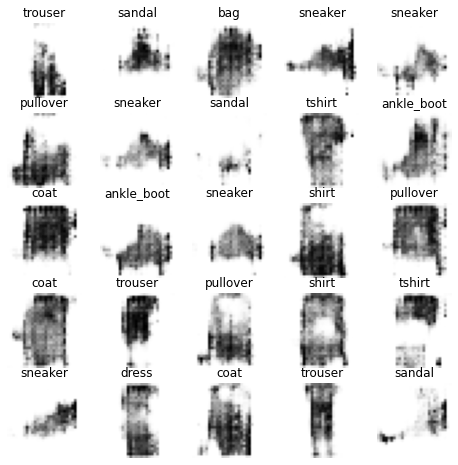

1875/1875 Epoch:3/10 	g_loss:0.8263773918151855 	d_loss:0.61994051933288577


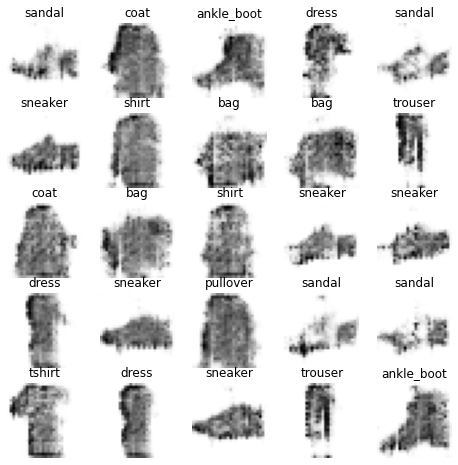

1875/1875 Epoch:4/10 	g_loss:1.1377630233764648 	d_loss:0.55126398801803595


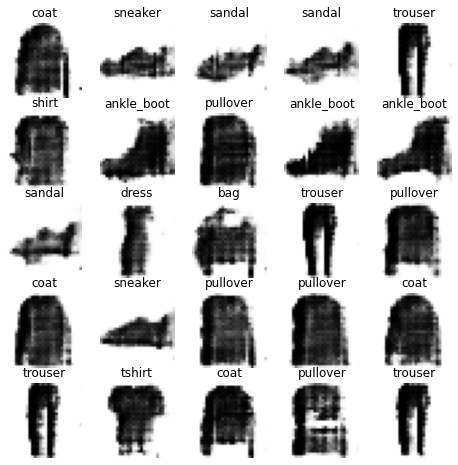

1875/1875 Epoch:5/10 	g_loss:0.8154052495956421 	d_loss:0.61886709928512576


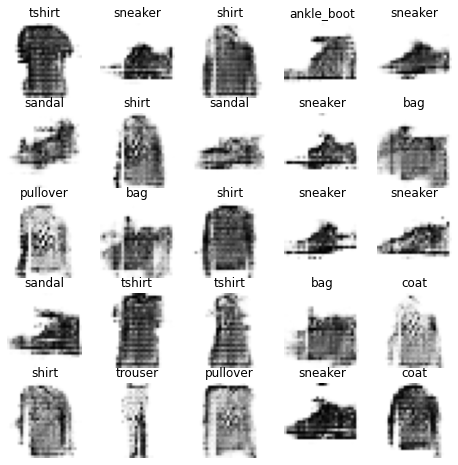

1875/1875 Epoch:6/10 	g_loss:0.8542737364768982 	d_loss:0.68179440498352054


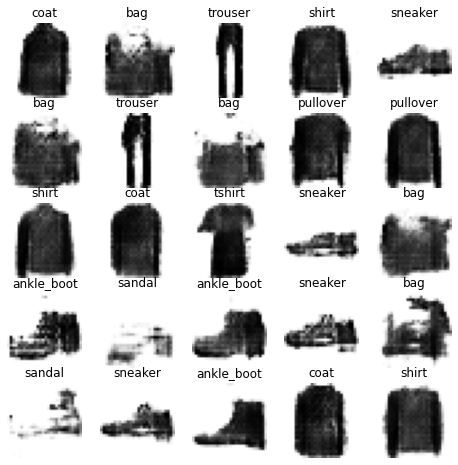

1875/1875 Epoch:7/10 	g_loss:0.9134974479675293 	d_loss:0.67356675863265996


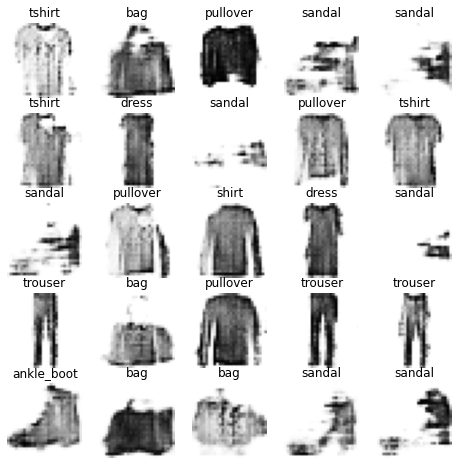

1875/1875 Epoch:8/10 	g_loss:0.7412676811218262 	d_loss:0.5846486091613779


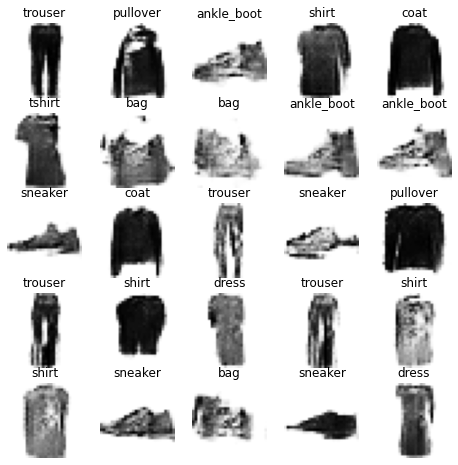

1875/1875 Epoch:9/10 	g_loss:0.7574182152748108 	d_loss:0.5949161052703857


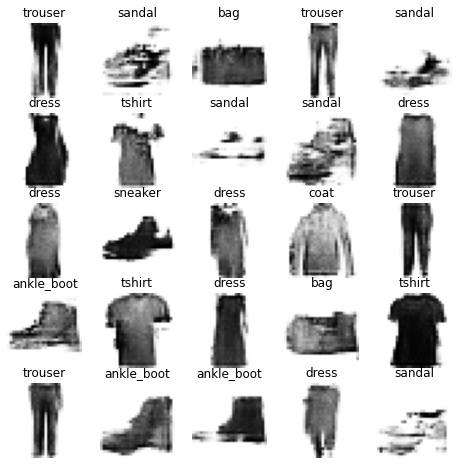

In [42]:
imgs = x_train #[:100]
labels = y_train #[:100]
train_loss_gen, train_loss_dis = train(gan, gen, dis, 
                                       latent_dim=100, 
                                       imgs=imgs, 
                                       labels=labels, 
                                       n_classes=10, 
                                       epochs=10, 
                                       batch_size=32)

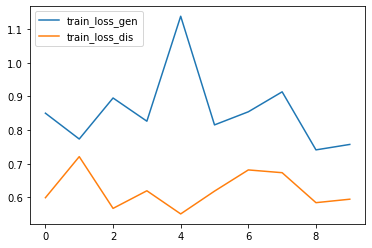

In [43]:
plt.plot(train_loss_gen, label="train_loss_gen")
plt.plot(train_loss_dis, label="train_loss_dis")
plt.legend(loc="upper left")
plt.show()

## B. CIFAR10

In [44]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
label_indicies = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
x_train.shape, y_train.shape

170500096/170498071 [==============================] - 4s 0us/step


((50000, 32, 32, 3), (50000, 1))